In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Project/Research/Median Filtering Forensics Based on Convlutional Neural Network')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os
import numpy as np
import random
import shutil
import glob
import itertools
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from utils import *
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
def createModel():
    model = Sequential()
    
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu', input_shape=(64, 64, 1)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))
    
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(5120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    return model

# Generating Data Set (Original uncompressed images and 3x3 Median filtered images)

In [ ]:
os.getcwd()

'/mnt/drive2/msc_2020/Convlutional Neural Network'

In [ ]:
os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network')

# if os.path.isdir('data/OMF3/train') is False:
#     os.mkdir('./data/OMF3/train')
#     os.mkdir('./data/OMF3/valid')
#     os.mkdir('./data/OMF3/test')
#     os.mkdir('./data/OMF3/train/original')
#     os.mkdir('./data/OMF3/train/MF3')
#     os.mkdir('./data/OMF3/valid/original')
#     os.mkdir('./data/OMF3/valid/MF3')
#     os.mkdir('./data/OMF3/test/original')
#     os.mkdir('./data/OMF3/test/MF3')

# ## Positive Data
# os.chdir('/mnt/drive2/msc_2020/ucid.v2')
# # # os.chdir('./../ucid.v2')

# for i in range(1, 1339):
#     name = 'ucid'+(str(i).zfill(5))+'.tif'
#     I = cv2.imread(name, 0)
#     np.clip(I, 0, 255, out=I)
#     I.astype('uint8')
#     I = cv2.medianBlur(I, 3)          # MP3 filtered data
#     I = cv2.medianBlur(I, 3) - I      # MFR-filter layer
#     if I.shape == (512, 384):
#         I = I.T
#     for j in range(6):
#         I_crop = crop(I, j)
#         cv2.imwrite(f'./../Convlutional Neural Network/data/OMF3/O-{j}{name}', I_crop)

# ## Negative Data

# for i in range(1, 1339):
#     name = 'ucid'+(str(i).zfill(5))+'.tif'
#     I = cv2.imread(name, 0)
#     np.clip(I, 0, 255, out=I)
#     I.astype('uint8')
#     I = cv2.medianBlur(I, 3) - I
#     if I.shape == (512, 384):
#         I = I.T
#     for j in range(6):
#         I_crop = crop(I, j)
#         cv2.imwrite(f'./../Convlutional Neural Network/data/OMF3/MF3-{j}{name}', I_crop)
        
# os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network/data/OMF3')
# for c in random.sample(glob.glob('O*'), 4014):
#     shutil.move(c, './train/original')

# for c in random.sample(glob.glob('MF3*'), 4014):
#     shutil.move(c, './train/MF3')

# for c in random.sample(glob.glob('O*'), 2007):
#     shutil.move(c, './valid/original')

# for c in random.sample(glob.glob('MF3*'), 2007):
#     shutil.move(c, './valid/MF3')

# for c in random.sample(glob.glob('O*'), 2007):
#     shutil.move(c, './test/original')

# for c in random.sample(glob.glob('MF3*'), 2007):
#     shutil.move(c, './test/MF3')

In [ ]:
os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network/data/OMF3')
print(os.getcwd())

/mnt/drive2/msc_2020/Convlutional Neural Network/data/OMF3


In [ ]:
train_path = './train'
valid_path = './valid'
test_path = './test'

In [ ]:
train_batches = ImageDataGenerator().flow_from_directory(directory=train_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['original', 'MF3'], shuffle=True)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['original', 'MF3'], shuffle=True)
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(64, 64), 
                        color_mode='grayscale', batch_size=256, classes=['original', 'MF3'], shuffle=False)

Found 8028 images belonging to 2 classes.
Found 4014 images belonging to 2 classes.
Found 4014 images belonging to 2 classes.


In [ ]:
# upto this step data is not shuffled it'll be shuffled when model.fit() function is called.
train_batches.labels[-100:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
OMF3_model = createModel()

In [ ]:
OMF3_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
OMF3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       8

In [ ]:
history = OMF3_model.fit(x=train_batches, steps_per_epoch=train_batches.samples//train_batches.batch_size, 
                validation_data=valid_batches,validation_steps=valid_batches.samples//valid_batches.batch_size,
                epochs=50, verbose=2)

Epoch 1/50
31/31 - 5s - loss: 70246.6719 - accuracy: 0.5320 - val_loss: 0.6592 - val_accuracy: 0.5120
Epoch 2/50
31/31 - 5s - loss: 1.0050 - accuracy: 0.5567 - val_loss: 0.6373 - val_accuracy: 0.8836
Epoch 3/50
31/31 - 4s - loss: 0.8125 - accuracy: 0.5639 - val_loss: 0.5794 - val_accuracy: 0.5003
Epoch 4/50
31/31 - 4s - loss: 8.3139 - accuracy: 0.5181 - val_loss: 0.7639 - val_accuracy: 0.5008
Epoch 5/50
31/31 - 4s - loss: 3.9647 - accuracy: 0.5579 - val_loss: 0.6849 - val_accuracy: 0.6513
Epoch 6/50
31/31 - 4s - loss: 1.3305 - accuracy: 0.5467 - val_loss: 0.6981 - val_accuracy: 0.5010
Epoch 7/50
31/31 - 4s - loss: 1.4480 - accuracy: 0.5239 - val_loss: 0.6501 - val_accuracy: 0.5013
Epoch 8/50
31/31 - 4s - loss: 0.7624 - accuracy: 0.5401 - val_loss: 0.6990 - val_accuracy: 0.4984
Epoch 9/50
31/31 - 5s - loss: 2.0042 - accuracy: 0.5265 - val_loss: 1.1641 - val_accuracy: 0.4997
Epoch 10/50
31/31 - 4s - loss: 2.0825 - accuracy: 0.5555 - val_loss: 0.6034 - val_accuracy: 0.7760
Epoch 11/50
31/

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

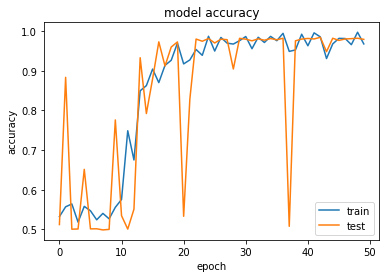

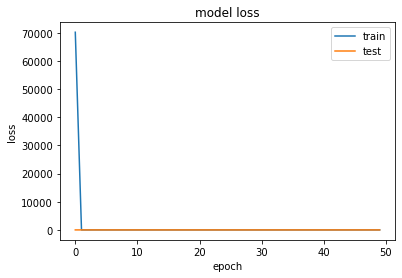

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
steps_per_epoch=test_batches.samples/test_batches.batch_size
steps_per_epoch

15.6796875

In [ ]:
predictions = OMF3_model.predict(x=test_batches, verbose=1, steps=test_batches.samples//test_batches.batch_size+1)

16/16 [==============================] - 1s 60ms/step


In [ ]:
np.argmax(predictions, axis=-1)

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
(test_batches.classes).shape, np.argmax(predictions, axis=-1).shape

((4014,), (4014,))

In [ ]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
test_batches.class_indices

{'original': 0, 'MF3': 1}

Confusion matrix, without normalization
[[1988   19]
 [  63 1944]]


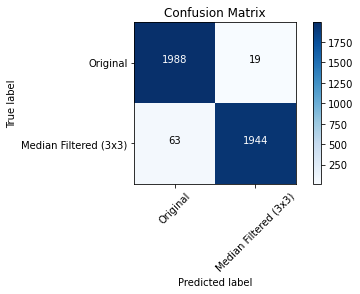

In [ ]:
cm_plot_labels = ['Original', 'Median Filtered (3x3)']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network')
if os.path.isfile('models/OMF3_model.h5') is False:
    OMF3_model.save('./models/OMF3_model.h5')

Reference https://youtu.be/qFJeN9V1ZsI?t=3124

Reference https://youtu.be/qFJeN9V1ZsI?t=3182

VGG16 Transfer tranning https://youtu.be/qFJeN9V1ZsI?t=4298


In [ ]:
# OMF3_model = load_model('/mnt/drive2/msc_2020/Convlutional Neural Network/models/OMF3_model', compile=True)
OMF3_model = load_model('./models/OMF3_model.h5', compile=True)

$\textbf{Manual Prediction}$ \\
$[0., 1.]$ means non median filtered images \\
$[1., 0.]$ means median filtered images

Positive
[[1. 0.]]


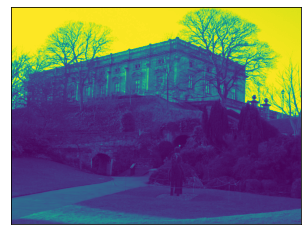

In [ ]:
# os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network')

I = cv2.imread('ucid00001.tif', 0)
image = I.copy()
np.clip(I, 0, 255, out=I)
I.astype('uint8')
I = cv2.medianBlur(I, 3)          # MP3 filtered data
I = cv2.medianBlur(I, 3) - I
shape = I.shape
I = I[shape[0]//2-32:shape[0]//2+32, shape[1]//2-32:shape[1]//2+32]
I = I.reshape(1, 64, 64, 1)

plt.imshow(image)
plt.xticks([]); plt.yticks([])

prediction = np.round(OMF3_model.predict(I))
if prediction[0][0] == 0:
    print('Negative')
else:
    print('Positive')
    
print(prediction)

# Generating Data Set (JPEG 70 compressed images and 3x3 Median filtered images)

Creating JPEG_70 Images

In [ ]:
os.getcwd()

'/home/mtech1/Desktop/Resarch/CNN'

In [ ]:
# os.chdir('/mnt/drive2/msc_2020/ucid.v2')
os.chdir('/home/mtech1/Desktop/Resarch/ucid.v2')
if os.path.isdir('./JPEG70') is False:
    os.mkdir('JPEG70')
    for i in range(1, 1339):
        img = 'ucid'+(str(i).zfill(5))+'.tif'
        I = Image.open(img)
        name, ext = img.split('.')
        image_70 = os.path.join(f'./JPEG70/{name}.jpeg')
        I.save(image_70,"JPEG", quality=70)

In [ ]:
# os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network')
# os.chdir('/home/mtech1/Desktop/Resarch/CNN')

# if os.path.isdir('.data/JPEG70MF3/train') is False:
#     os.mkdir('./data/JPEG70MF3/train')
#     os.mkdir('./data/JPEG70MF3/valid')
#     os.mkdir('./data/JPEG70MF3/test')
#     os.mkdir('./data/JPEG70MF3/train/JPEG70')
#     os.mkdir('./data/JPEG70MF3/train/JPEG70MF3')
#     os.mkdir('./data/JPEG70MF3/valid/JPEG70')
#     os.mkdir('./data/JPEG70MF3/valid/JPEG70MF3')
#     os.mkdir('./data/JPEG70MF3/test/JPEG70')
#     os.mkdir('./data/JPEG70MF3/test/JPEG70MF3')


# os.chdir('/mnt/drive2/msc_2020/ucid.v2/JPEG_70')
# os.chdir('./../ucid.v2')
os.chdir('/home/mtech1/Desktop/Resarch/ucid.v2/JPEG70')

## Positive Data

for i in range(1, 1339):
    name = 'ucid'+(str(i).zfill(5))+'.jpeg'
    I = cv2.imread(name, 0)
    np.clip(I, 0, 255, out=I)
    I.astype('uint8')
    I = cv2.medianBlur(I, 3)          # MP3 filtered data
    I = cv2.medianBlur(I, 3) - I      # MFR-filter layer
    if I.shape == (512, 384):
        I = I.T
    for j in range(6):
        I_crop = crop(I, j)
#         cv2.imwrite(f'./../../Convlutional Neural Network/data/JPEG70MF3/JPEG-{j}{name}', I_crop)
        cv2.imwrite(f'./../../CNN/data/JPEG70MF3/JPEG-{str(j)}{name}', I_crop)

## Negative Data

for i in range(1, 1339):
    name = 'ucid'+(str(i).zfill(5))+'.jpeg'
    I = cv2.imread(name, 0)
    np.clip(I, 0, 255, out=I)
    I.astype('uint8')
    I = cv2.medianBlur(I, 3) - I     # MFR-filter layer
    if I.shape == (512, 384):
        I = I.T
    for j in range(6):
        I_crop = crop(I, j)
#         cv2.imwrite(f'./../../Convlutional Neural Network/data/JPEG70MF3/MF3-{j}{name}', I_crop)
        cv2.imwrite(f'./../../CNN/data/JPEG70MF3/MF3-{str(j)}{name}', I_crop)

# # os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network/data/JPEG70MF3')
os.chdir('/home/mtech1/Desktop/Resarch/CNN/data/JPEG70MF3')
for c in random.sample(glob.glob('JPEG*'), 4014):
    shutil.move(c, './train/JPEG70')

for c in random.sample(glob.glob('MF3*'), 4014):
    shutil.move(c, './train/JPEG70MF3')

for c in random.sample(glob.glob('JPEG*'), 2007):
    shutil.move(c, './valid/JPEG70')

for c in random.sample(glob.glob('MF3*'), 2007):
    shutil.move(c, './valid/JPEG70MF3')

for c in random.sample(glob.glob('JPEG*'), 2007):
    shutil.move(c, './test/JPEG70')

for c in random.sample(glob.glob('MF3*'), 2007):
    shutil.move(c, './test/JPEG70MF3')

In [ ]:
# os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network/data/JPEG70MF3')
os.chdir('/home/mtech1/Desktop/Resarch/CNN/data/JPEG70MF3')
print(os.getcwd())

/home/mtech1/Desktop/Resarch/CNN/data/JPEG70MF3


In [ ]:
train_path = './train'
valid_path = './valid'
test_path = './test'
train_batches = ImageDataGenerator().flow_from_directory(directory=train_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['JPEG70', 'JPEG70MF3'], shuffle=True)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['JPEG70', 'JPEG70MF3'], shuffle=True)
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(64, 64), 
                        color_mode='grayscale', batch_size=256, classes=['JPEG70', 'JPEG70MF3'], shuffle=False)

Found 8028 images belonging to 2 classes.
Found 4014 images belonging to 2 classes.
Found 4014 images belonging to 2 classes.


In [ ]:
JPEG70_MF3_model = createModel()
JPEG70_MF3_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
JPEG70_MF3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       8

In [ ]:
history = JPEG70_MF3_model.fit(x=train_batches,
            steps_per_epoch=train_batches.samples//train_batches.batch_size+1, validation_data=valid_batches,
            validation_steps=valid_batches.samples//valid_batches.batch_size+1, epochs=50, verbose=2)

Epoch 1/50
31/31 - 173s - loss: 36549.6133 - accuracy: 0.5239 - val_loss: 0.6680 - val_accuracy: 0.5435
Epoch 2/50


KeyboardInterrupt: 

In [ ]:
history.history.keys()

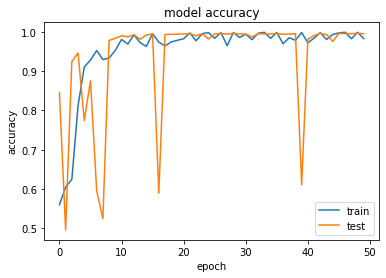

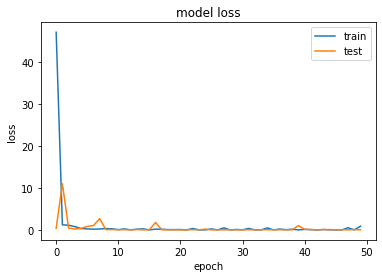

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
JPEG70_MF3_model.predict(x=test_batches, verbose=1)

251/251 [==============================] - 2s 10ms/step - loss: 0.0258 - accuracy: 0.9949


[0.025842010974884033, 0.9948928952217102]

In [ ]:
np.argmax(predictions, axis=-1)
np.round(predictions)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels = ['JPEG_70', 'Median Filtered (3x3)']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
if os.path.isfile('models/JPEG70_MF3_model.h5') is False:
    OMF3_model.save('./models/JPEG70_MF3_model.h5')

In [ ]:
JPEG70_MF3_model = load_model('/mnt/drive2/msc_2020/Convlutional Neural Network/models/JPEG70_MF3_model.h5', compile=True)

Positive


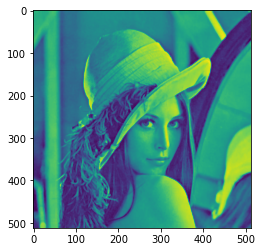

In [ ]:
# os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network')

I = cv2.imread('Lena.jpeg', 0)
image = I.copy()
np.clip(I, 0, 255, out=I)
I.astype('uint8')
I = cv2.medianBlur(I, 3)          # MP3 filtered data
I = cv2.medianBlur(I, 3) - I
shape = I.shape
I = I[shape[0]//2-32:shape[0]//2+32, shape[1]//2-32:shape[1]//2+32]
I = I.reshape(1, 64, 64, 1)

plt.imshow(image)
plt.xticks([]); plt.yticks([])

prediction = np.round(JPEG70_MF3_model.predict(I))
if prediction[0][0] == 0:
    print('Negative')
else:
    print('Positive')
    
print(prediction)

$\textbf{Combined Model}$

In [ ]:
combined_model = createModel()
combined_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
os.chdir('/content/drive/My Drive/Project/Research/Median Filtering Forensics Based on Convlutional Neural Network/data/combined')

In [ ]:
train_path = './train'
valid_path = './valid'
test_path = './test'

train_batches = ImageDataGenerator().flow_from_directory(directory=train_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['Negative', 'MF3'], shuffle=True)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(64, 64),
                        color_mode='grayscale', batch_size=256, classes=['Negative', 'MF3'], shuffle=True)
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(64, 64), 
                        color_mode='grayscale', batch_size=256, classes=['Negative', 'MF3'], shuffle=False)

In [ ]:
history = JPEG70_MF3_model.fit(x=train_batches,
            steps_per_epoch=train_batches.samples//train_batches.batch_size, validation_data=valid_batches,
            validation_steps=valid_batches.samples//valid_batches.batch_size, epochs=50, verbose=2)

In [ ]:
history.history.keys()

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
combined_model.predict(x=test_batches, verbose=1)

In [ ]:
np.argmax(predictions, axis=-1)
np.round(predictions)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels = ['Negative', 'Median Filtered (3x3)']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
if os.path.isfile('models/combined_model.h5') is False:
    OMF3_model.save('./models/combined_model.h5')

In [ ]:
JPEG70_MF3_model = load_model('/mnt/drive2/msc_2020/Convlutional Neural Network/models/combined_model.h5', compile=True)

In [ ]:
# os.chdir('/mnt/drive2/msc_2020/Convlutional Neural Network')

I = cv2.imread('Lena.jpeg', 0)
image = I.copy()
np.clip(I, 0, 255, out=I)
I.astype('uint8')
I = cv2.medianBlur(I, 3)          # MP3 filtered data
I = cv2.medianBlur(I, 3) - I
shape = I.shape
I = I[shape[0]//2-32:shape[0]//2+32, shape[1]//2-32:shape[1]//2+32]
I = I.reshape(1, 64, 64, 1)

plt.imshow(image)
plt.xticks([]); plt.yticks([])

prediction = np.round(JPEG70_MF3_model.predict(I))
if prediction[0][0] == 0:
    print('Negative')
else:
    print('Positive')
    
print(prediction)